### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

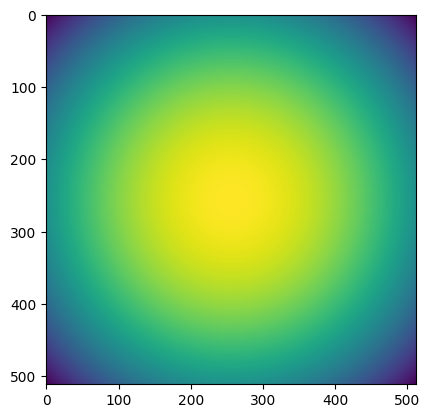

In [23]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 512 #[256, 512, 1024]

##time
t0 = 0
t1 = 10 
'''
time_steps = 20
dt = (t1 - t0)/time_steps
'''

##load(constant)
W = 1e0  # Total load

L = 2.  # Domain size
Radius = 0.1

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] ###????????????


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [24]:


'''
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#solver.solve(p_target)

#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)


for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(np.mean(model.traction > 0)*L**2)

np.save('Ac_tamaas', Ac_tamaas)#np.save(f"Ac_tamaas_{n}", Ac_tamaas)
'''


'\nAc_tamaas = []\n\n#solve for target pressure\np_target = W / (L**2) #avarge pressure\n#solver.solve(p_target)\n\n#solver\nsolver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)\n\n\nfor t in np.linspace(t0, t1, time_steps):\n    solver.solve(p_target)\n    Ac_tamaas.append(np.mean(model.traction > 0)*L**2)\n\nnp.save(\'Ac_tamaas\', Ac_tamaas)#np.save(f"Ac_tamaas_{n}", Ac_tamaas)\n'

In [25]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5

##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]
'''
for t in np.arange(t0, t1, dt):        
    Ac_Johnson_ref.append((3/8 * Radius * W * (1/g_1 + 1/g_2*(1-np.exp(-t/tau_c[0]))))**(2/3)*np.pi)
'''
tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

 Iter          Cost_f           Error
    0    3.600612e-02    1.921916e-02
   85    1.271156e-01    8.743103e-13
 Iter          Cost_f           Error
    0    6.356264e-02    8.942782e-03
   89    1.544198e-01    8.173142e-13
 Iter          Cost_f           Error
    0    7.852339e-02    6.691863e-03
   85    1.748285e-01    9.696181e-13
 Iter          Cost_f           Error
    0    8.980005e-02    4.956182e-03
   87    1.902151e-01    7.518969e-13
 Iter          Cost_f           Error
    0    9.835306e-02    3.655165e-03
   86    2.019100e-01    8.317387e-13
 Iter          Cost_f           Error
    0    1.048747e-01    2.682556e-03
   82    2.108580e-01    4.352949e-13
 Iter          Cost_f           Error
    0    1.098680e-01    1.971214e-03
   83    2.177438e-01    8.656721e-13
 Iter          Cost_f           Error
    0    1.137074e-01    1.432716e-03
   77    2.230654e-01    6.775388e-13
 Iter          Cost_f           Error
    0    1.166694e-01    1.061664e-03
   77    2.2

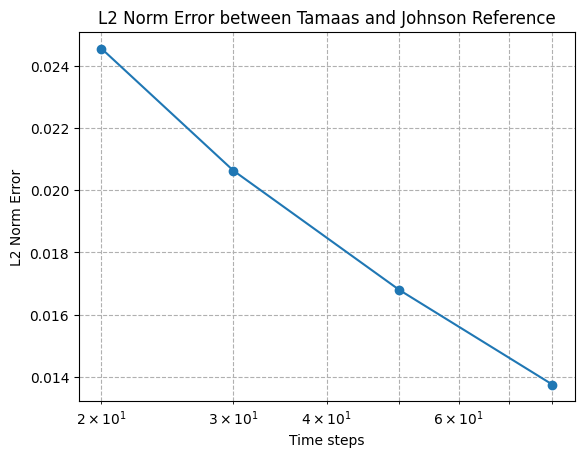

In [27]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#solver.solve(p_target)
time_steps_list = [20, 30, 50, 80]
L2_norms = []


for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

    for t in np.linspace(t0, t1, time_steps):
        solver.solve(p_target)
        Ac_tamaas.append(np.mean(model.traction > 0) * L**2)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * W * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)

    # Calculate L2 norm between Ac_tamaas and Ac_Johnson_ref
    L2_error = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
    L2_norms.append(L2_error)


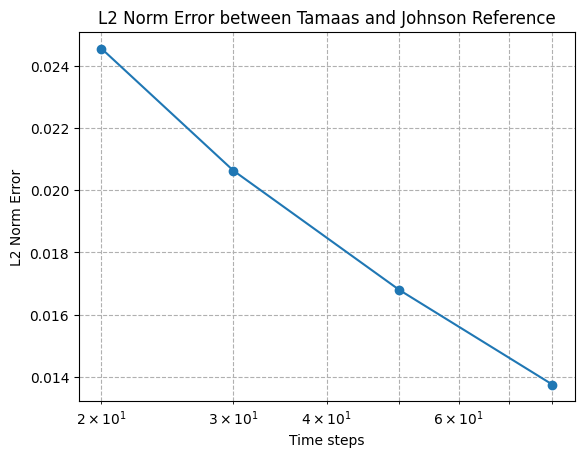

In [30]:

# Plot log-log graph of L2 norms
plt.figure()
plt.plot(time_steps_list, L2_norms, marker='o')
plt.xlabel('Time steps')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

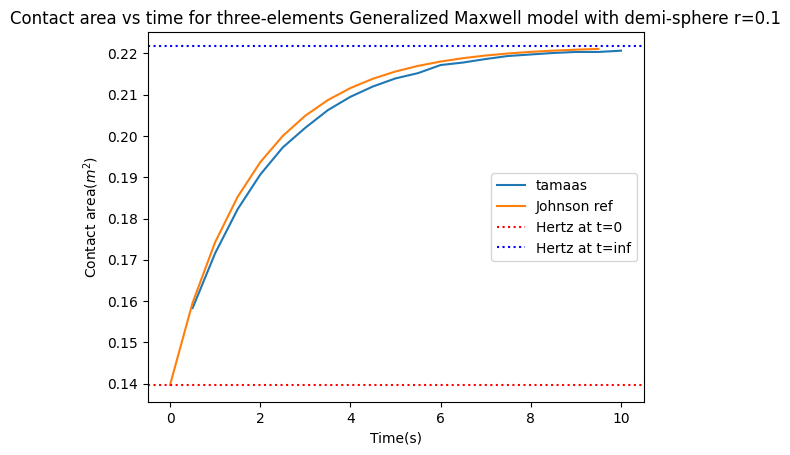

In [18]:
'''
plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["tamaas","Johnson ref", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for three-elements Generalized Maxwell model with demi-sphere r=0.1")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()
'''